In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data = pd.read_csv("./data/data.csv")

data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,liked
0,0.803,0.6240,7,-6.764,0,0.0477,0.451,0.000734,0.1000,0.6280,95.968,304524,4,0
1,0.762,0.7030,10,-7.951,0,0.3060,0.206,0.000000,0.0912,0.5190,151.329,247178,4,1
2,0.261,0.0149,1,-27.528,1,0.0419,0.992,0.897000,0.1020,0.0382,75.296,286987,4,0
3,0.722,0.7360,3,-6.994,0,0.0585,0.431,0.000001,0.1230,0.5820,89.860,208920,4,1
4,0.787,0.5720,1,-7.516,1,0.2220,0.145,0.000000,0.0753,0.6470,155.117,179413,4,1


### Rozkład danych

array([[<AxesSubplot: title={'center': 'danceability'}>,
        <AxesSubplot: title={'center': 'energy'}>,
        <AxesSubplot: title={'center': 'key'}>,
        <AxesSubplot: title={'center': 'loudness'}>],
       [<AxesSubplot: title={'center': 'mode'}>,
        <AxesSubplot: title={'center': 'speechiness'}>,
        <AxesSubplot: title={'center': 'acousticness'}>,
        <AxesSubplot: title={'center': 'instrumentalness'}>],
       [<AxesSubplot: title={'center': 'liveness'}>,
        <AxesSubplot: title={'center': 'valence'}>,
        <AxesSubplot: title={'center': 'tempo'}>,
        <AxesSubplot: title={'center': 'duration_ms'}>],
       [<AxesSubplot: title={'center': 'time_signature'}>,
        <AxesSubplot: title={'center': 'liked'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

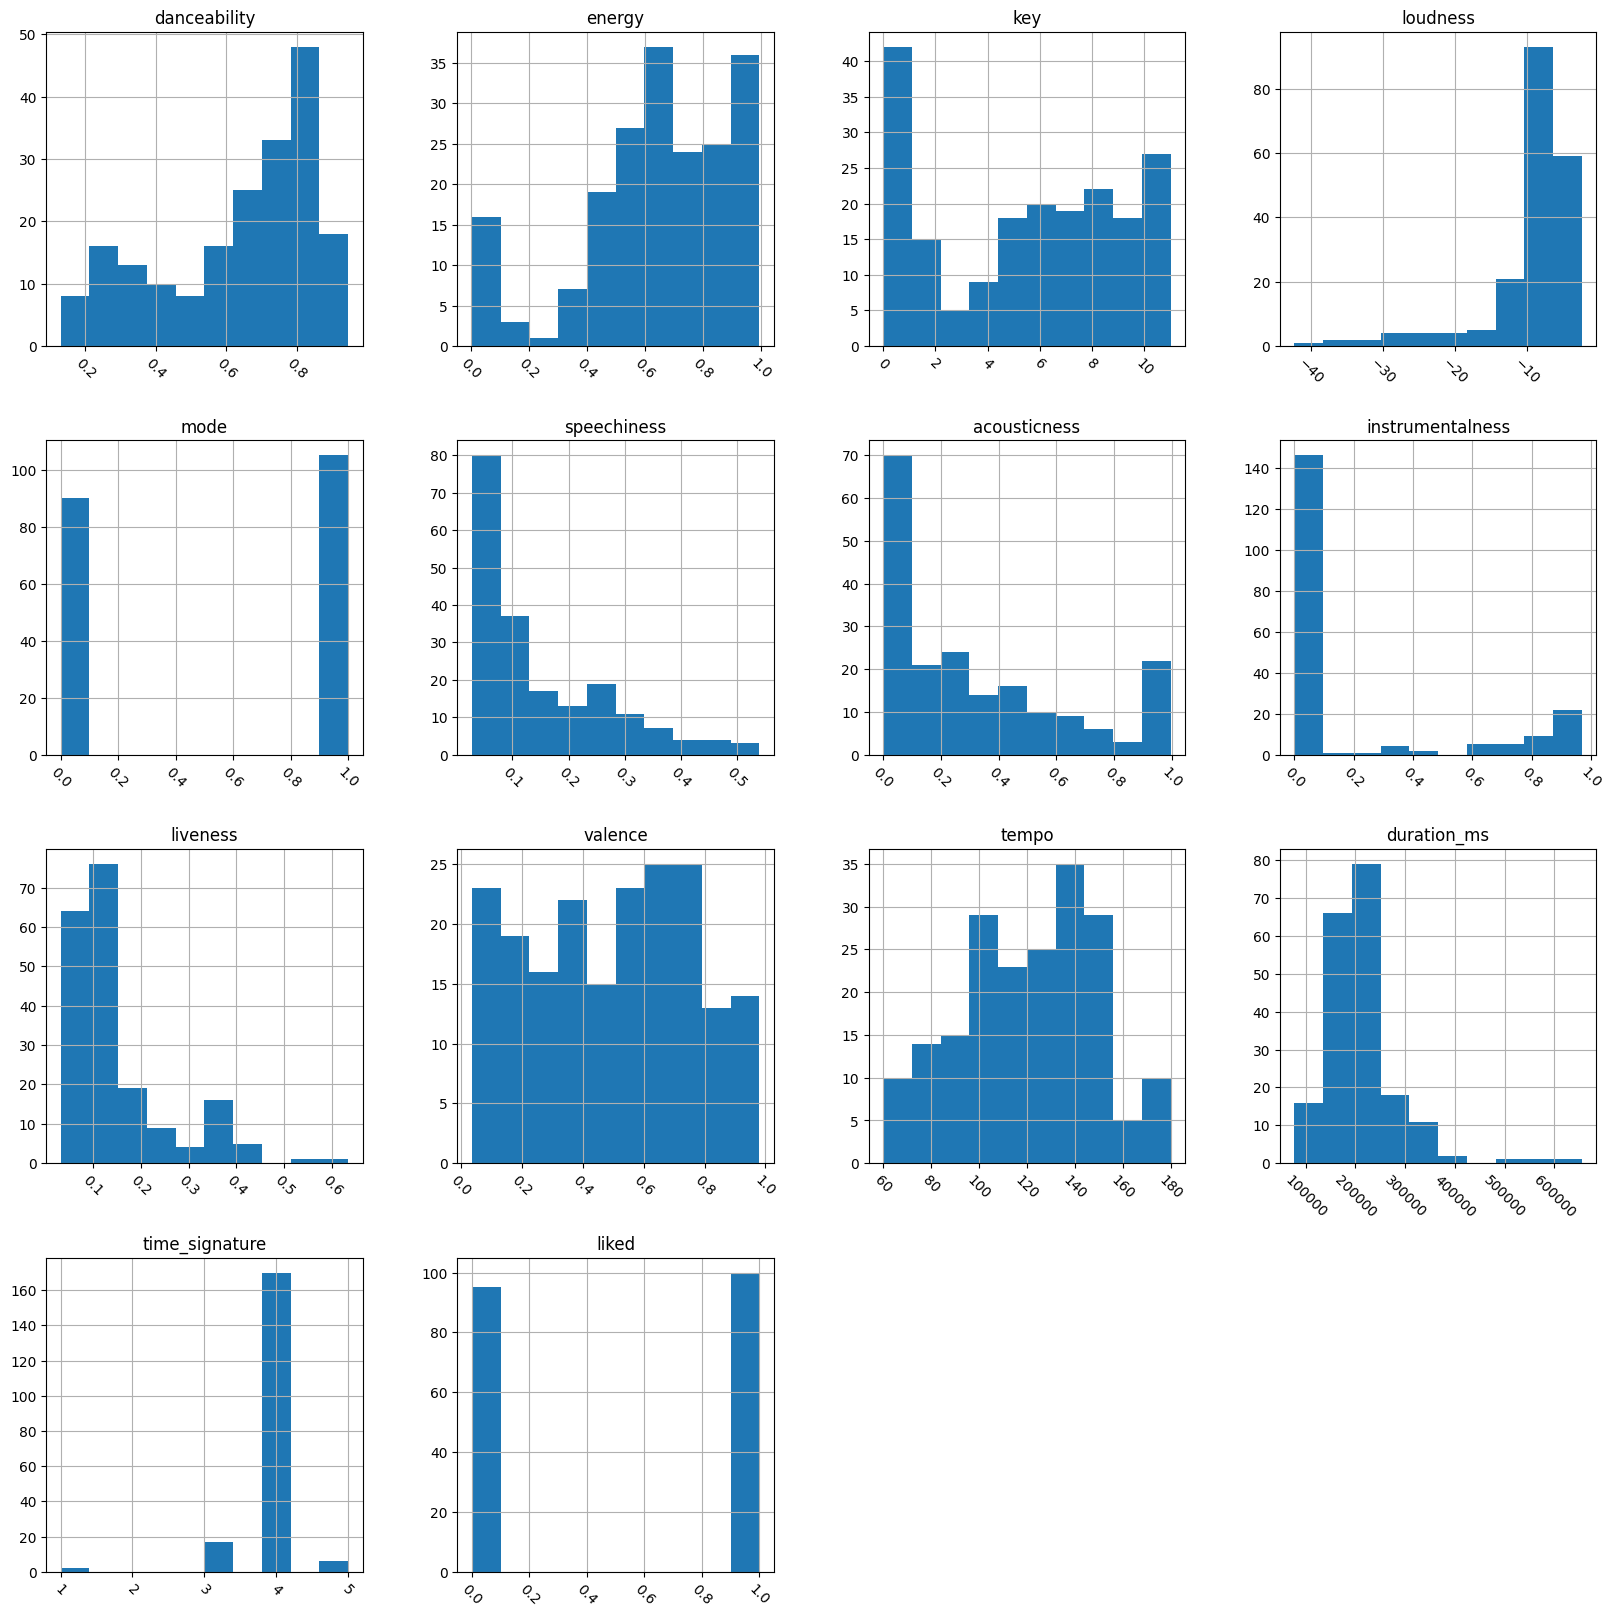

In [8]:
data.hist(figsize=(20, 20), xrot=-45)

In [12]:
y = data["liked"]
X = data.drop(labels = "liked", axis=1)

In [59]:
# sns.pairplot(data, hue="liked")

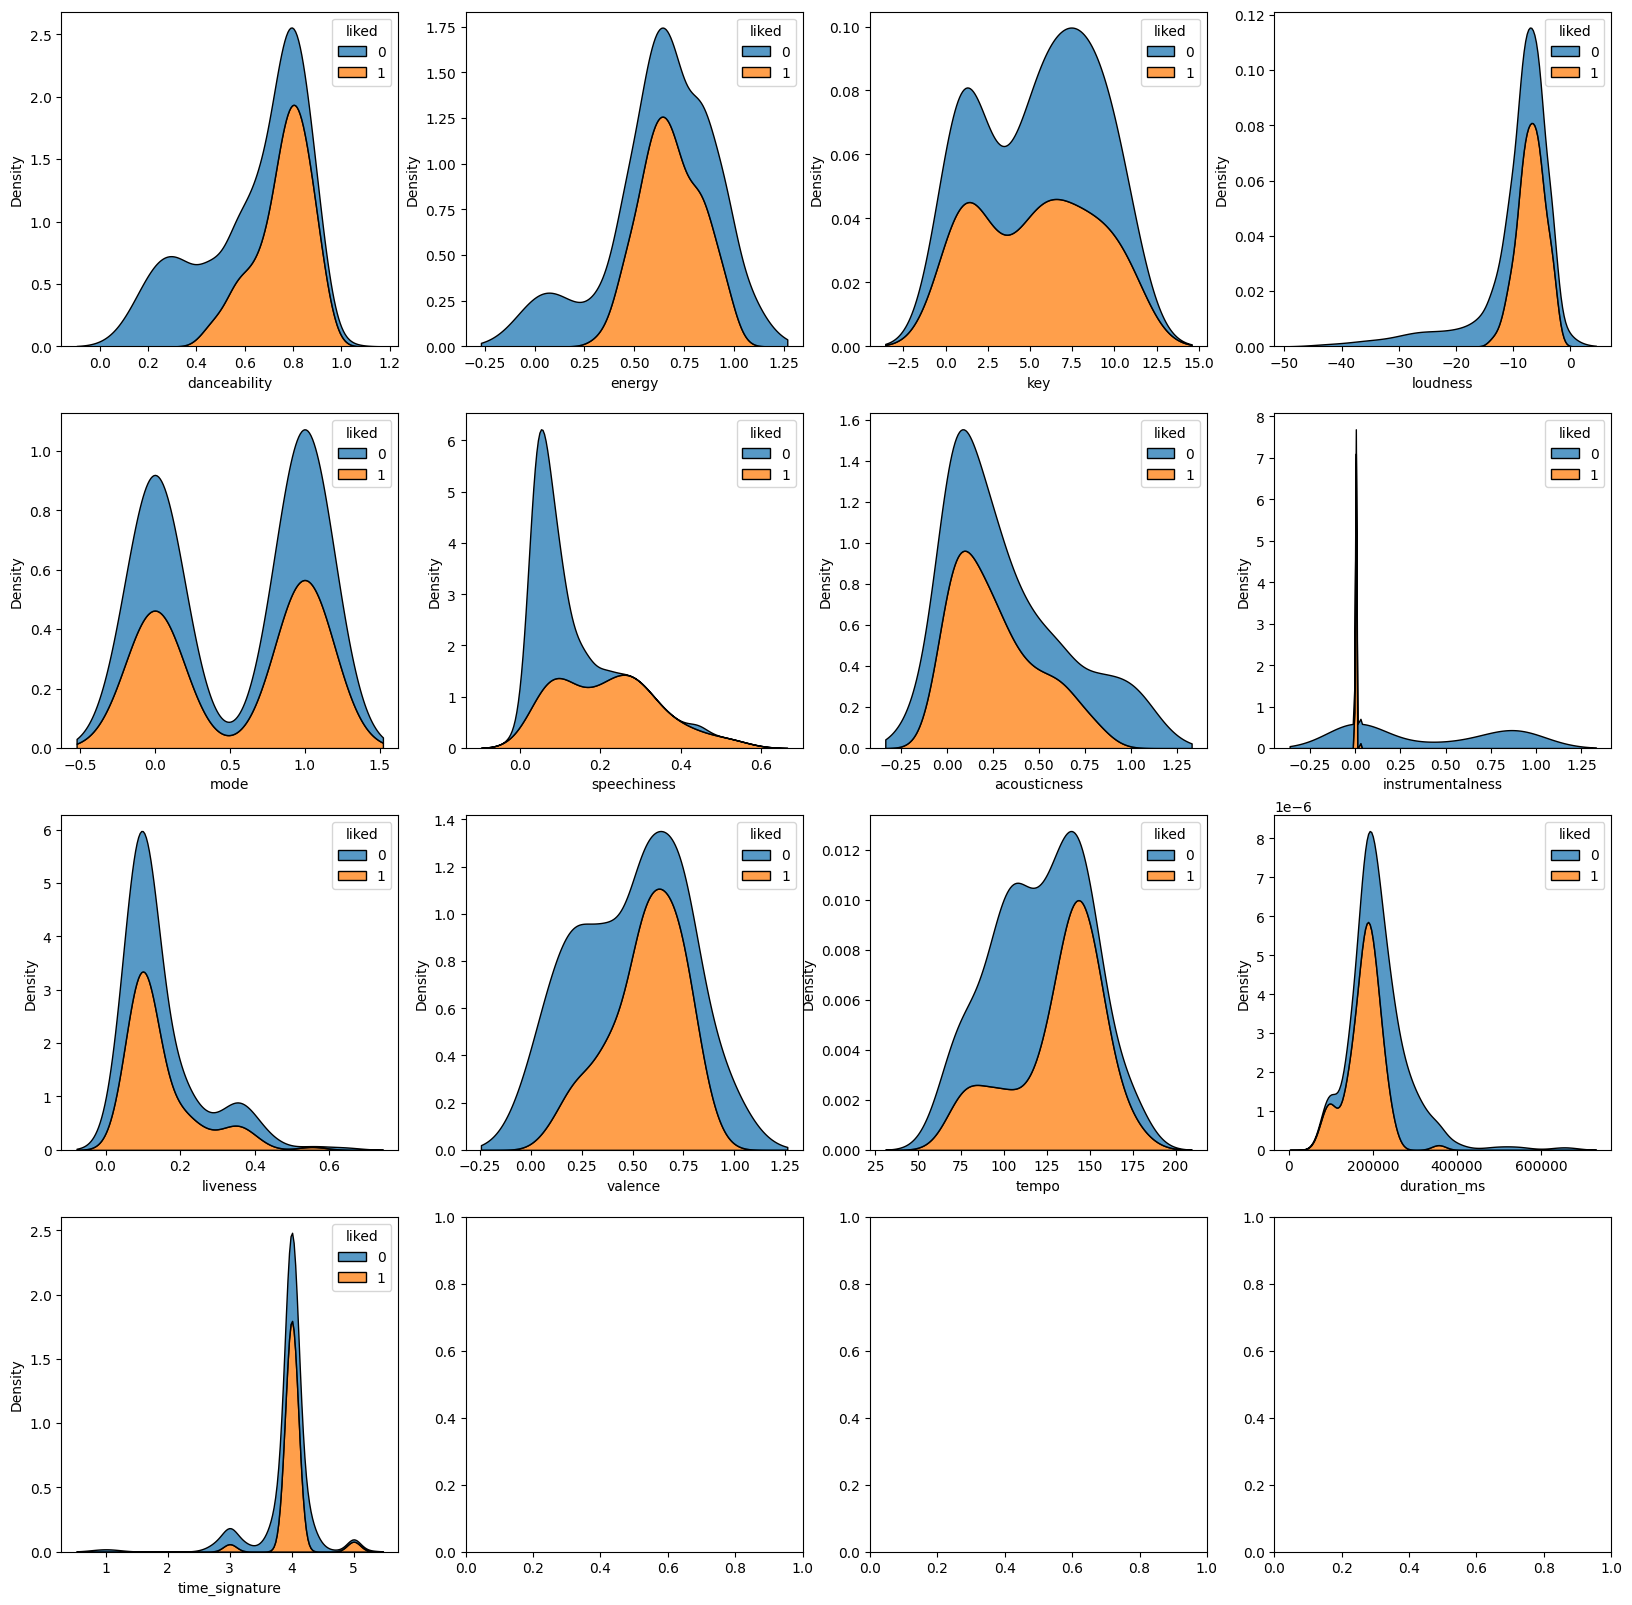

In [65]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for index, col in enumerate(X.columns):
    sns.kdeplot(data, x=col, hue="liked", ax=axes[index // 4][index % 4], multiple="stack")
    # sns.histplot(data, x=col, hue="liked", ax=axes[index // 4][index % 4])

<AxesSubplot: >

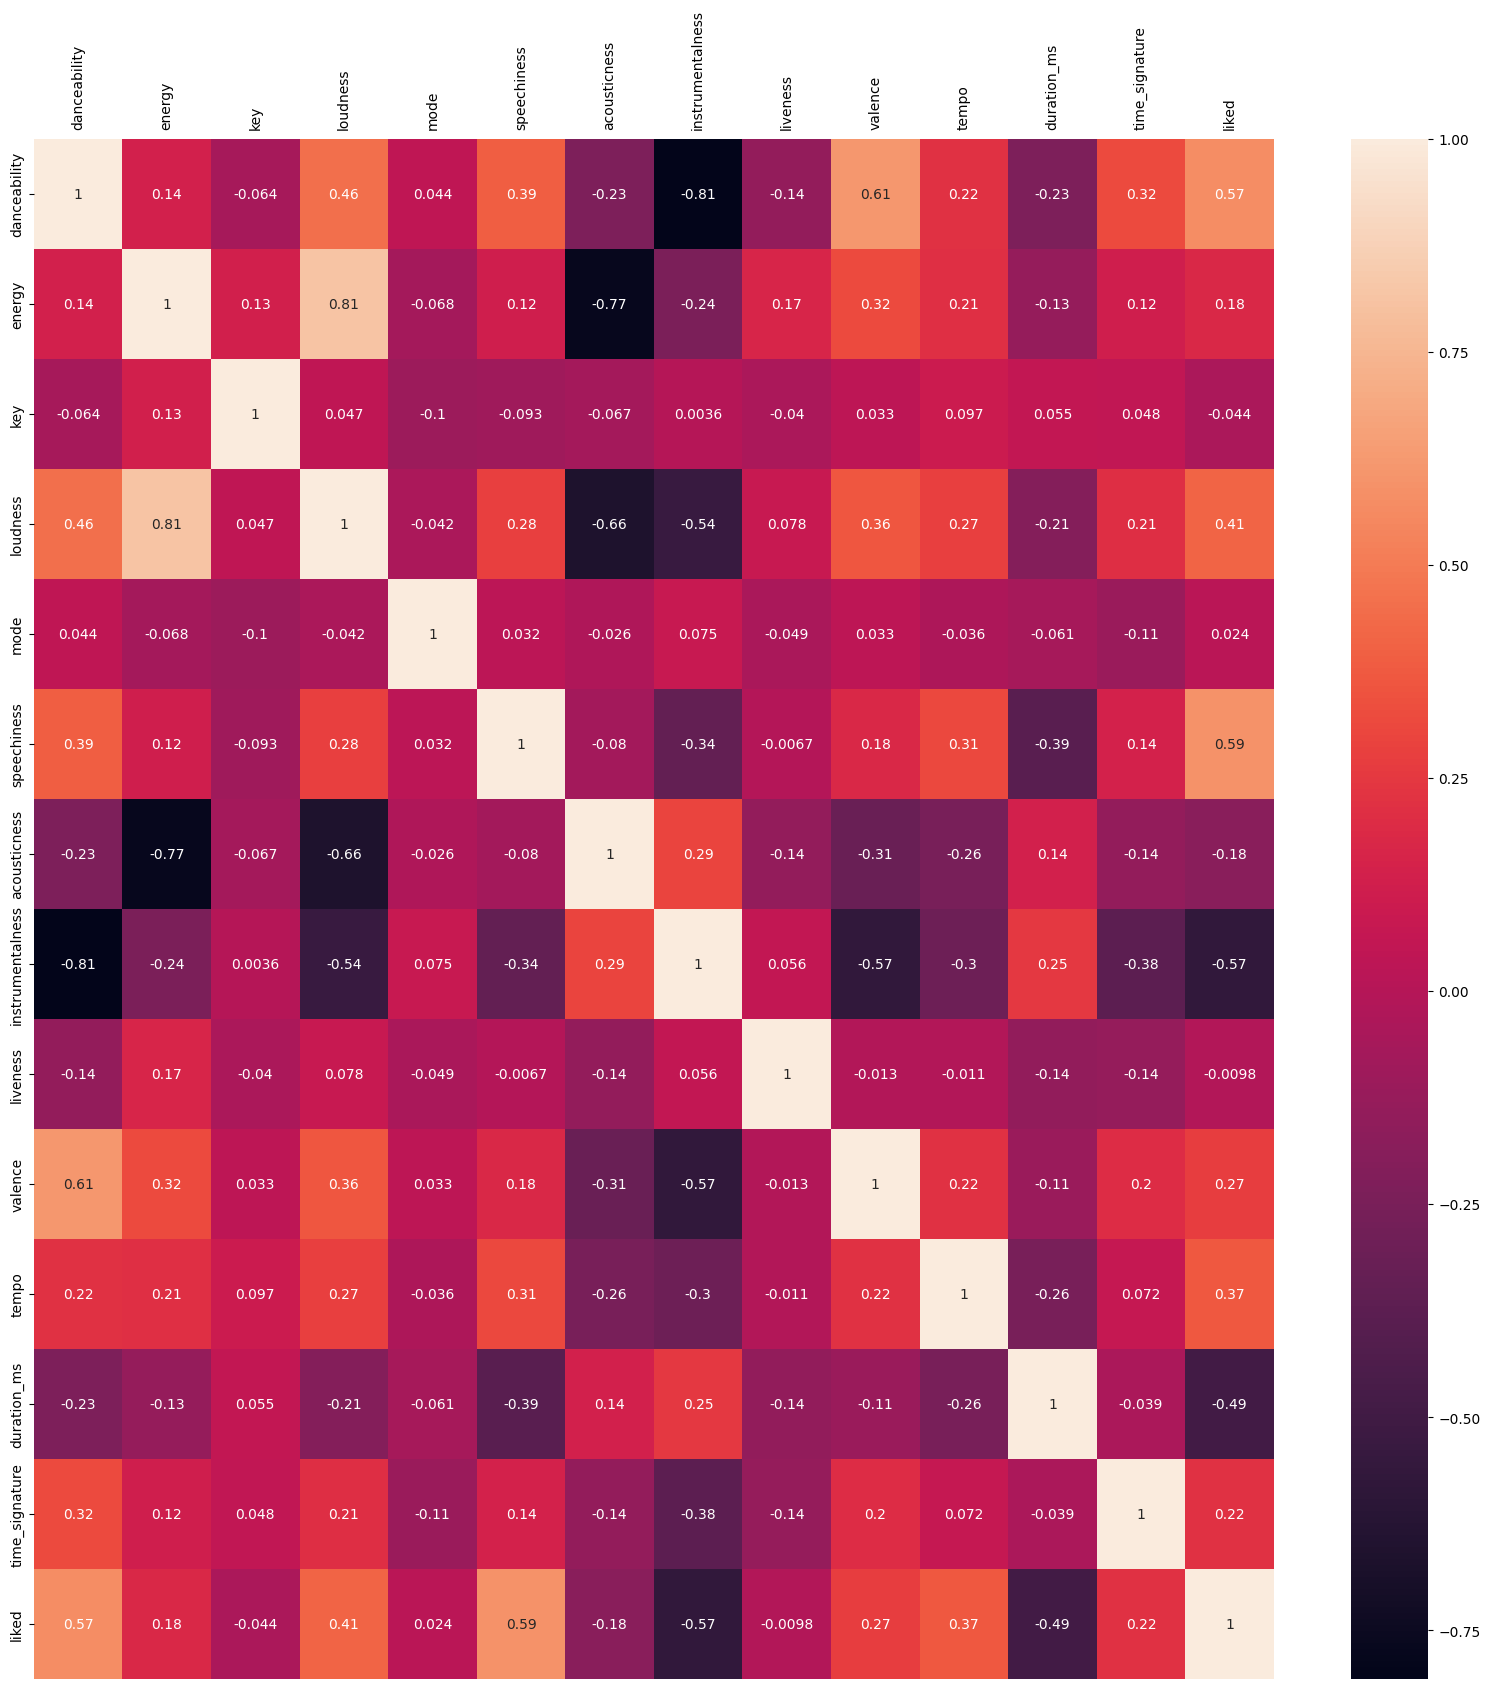

In [55]:
corr = data.corr()
plt.figure(figsize=(20,20))
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
sns.heatmap(corr, annot=True)